# Actividad 5: Visualización de Resultados y Validación Cruzada

# SECCIÓN 1: CONSTRUCCIÓN DE LA MUESTRA M (MUESTREO ESTRATIFICADO)

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, StringIndexerModel, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

spark = SparkSession.builder.appName('Actividad5_VisualizacionResultados').getOrCreate()

# Cargar datos
df = spark.read.csv('C:/Users/luis_/Downloads/archive/GUIDE_Train.csv', header=True, inferSchema=True)

# Limpiar los datos eliminando filas con valores nulos en columnas clave
cols_to_use = ["IncidentGrade", "EntityType", "ResourceType", "OSFamily", "Category"]
df_clean = df.dropna(subset=cols_to_use)

# Calcular las fracciones para el muestreo estratificado
fractions = df_clean.select("Category").distinct().withColumn("fraction", F.lit(0.3)).rdd.collectAsMap()

# Realizar el muestreo estratificado
M = df_clean.stat.sampleBy("Category", fractions, seed=42)

print("Muestra M (30% del total) construida exitosamente.")
print(f"Total de filas en la muestra M: {M.count()}")
M.groupBy("Category").count().orderBy(F.col("count").desc()).show(truncate=False)

Muestra M (30% del total) construida exitosamente.
Total de filas en la muestra M: 2170
+-------------------+-----+
|Category           |count|
+-------------------+-----+
|InitialAccess      |970  |
|Discovery          |593  |
|SuspiciousActivity |211  |
|Exfiltration       |115  |
|LateralMovement    |87   |
|PrivilegeEscalation|67   |
|CredentialAccess   |48   |
|Impact             |27   |
|Execution          |20   |
|DefenseEvasion     |15   |
|CommandAndControl  |12   |
|Persistence        |5    |
+-------------------+-----+



# SECCIÓN 2: PREPROCESAMIENTO DE DATOS PARA APRENDIZAJE AUTOMÁTICO

In [ ]:
# Crear una lista de las columnas de características a indexar
feature_cols_to_index = ["IncidentGrade", "EntityType", "ResourceType", "OSFamily"]

# Indexar las columnas de características en un bucle
for column in feature_cols_to_index:
    indexer = StringIndexer(inputCol=column, outputCol=column + "_idx", handleInvalid='keep')
    M = indexer.fit(M).transform(M)

# Indexar la columna objetivo ('Category') por separado y guardar el modelo ajustado
category_indexer = StringIndexer(inputCol="Category", outputCol="Category_idx", handleInvalid='keep')
category_indexer_model = category_indexer.fit(M)
M = category_indexer_model.transform(M)

# Ensamblar las características en un único vector
feature_cols = ["IncidentGrade_idx", "EntityType_idx", "ResourceType_idx", "OSFamily_idx"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
M_prepared = assembler.transform(M)

print("Datos preprocesados y listos para el entrenamiento.")
M_prepared.select(feature_cols + ["features", "Category_idx"]).show(5, truncate=False)

Datos preprocesados y listos para el entrenamiento.
+-----------------+--------------+----------------+------------+-----------------+------------+
|IncidentGrade_idx|EntityType_idx|ResourceType_idx|OSFamily_idx|features         |Category_idx|
+-----------------+--------------+----------------+------------+-----------------+------------+
|2.0              |0.0           |8.0             |0.0         |[2.0,0.0,8.0,0.0]|1.0         |
|1.0              |0.0           |0.0             |0.0         |(4,[0],[1.0])    |0.0         |
|0.0              |0.0           |0.0             |0.0         |(4,[],[])        |0.0         |
|0.0              |0.0           |11.0            |0.0         |(4,[2],[11.0])   |0.0         |
|0.0              |0.0           |1.0             |0.0         |(4,[2],[1.0])    |1.0         |
+-----------------+--------------+----------------+------------+-----------------+------------+
only showing top 5 rows



# SECCIÓN 3: EXPERIMENTACIÓN (MODELO SUPERVISADO CON VALIDACIÓN CRUZADA)

### 3.1. Definir un proceso de validación cruzada

Para obtener una medida robusta y fiable del rendimiento de nuestro modelo de clasificación, implementaremos la técnica de **validación cruzada k-fold**. Esta técnica consiste en dividir el conjunto de datos en 'k' subconjuntos (o "pliegues", *folds*) de tamaño similar. Luego, se entrena el modelo 'k' veces, utilizando en cada ocasión un pliegue diferente como conjunto de prueba y los 'k-1' pliegues restantes como conjunto de entrenamiento. El rendimiento final del modelo se calcula como el promedio de las métricas obtenidas en las 'k' iteraciones.

**Justificación de la elección de k = 5:**

Se ha elegido un valor de **k=5** por las siguientes razones:

- **Balance entre Sesgo y Varianza:** Un valor de k=5 es un estándar en la industria del aprendizaje automático. Ofrece un excelente equilibrio: reduce la varianza en la estimación del rendimiento en comparación con un k más bajo (como k=3) y evita el alto costo computacional de un k más alto (como k=10), que es una consideración crítica en un entorno de Big Data.

- **Representatividad de los Pliegues:** Con k=5, cada pliegue de validación contendrá el 20% de los datos de la muestra M. Este tamaño es lo suficientemente grande como para constituir una muestra representativa de los datos, asegurando que la evaluación del rendimiento en cada iteración sea estable y significativa.

- **Eficiencia Computacional:** En el contexto de Big Data, la eficiencia es clave. Realizar 5 ciclos de entrenamiento y evaluación (en lugar de 10 o más) permite una experimentación más rápida sin sacrificar significativamente la fiabilidad de los resultados. PySpark se encargará de distribuir esta carga de trabajo de manera eficiente a través del clúster.

### 3.2. Construcción de los “k-folds” definidos en paso 1

La construcción de los k-folds se realizará de manera automática utilizando la clase `CrossValidator` de la biblioteca PySpark ML. Esta herramienta está optimizada para entornos de Big Data y gestiona internamente la división de los datos en los 5 pliegues.

Una ventaja fundamental de `CrossValidator` es que implementa una **división estratificada**. Esto significa que al crear los pliegues, se preserva la proporción de cada clase de la variable objetivo (`Category`). Dado que nuestro conjunto de datos está desbalanceado (algunas categorías de ataques son mucho más frecuentes que otras), la estratificación es esencial para garantizar que cada pliegue sea una minirrepresentación fiel de la población de datos original. Esto evita que un pliegue tenga, por casualidad, muy pocas o ninguna muestra de una clase minoritaria, lo que conduciría a una evaluación de rendimiento sesgada y poco fiable.

### 3.3. Fase de entrenamiento
Ahora procedemos a la fase de experimentación. Configuraremos un clasificador `RandomForestClassifier` y una cuadrícula de hiperparámetros (`ParamGridBuilder`) para que `CrossValidator` encuentre la mejor combinación. El entrenamiento se realizará sobre la totalidad de la muestra `M_prepared`.

In [ ]:
# Modelo supervisado: Random Forest
rf = RandomForestClassifier(labelCol="Category_idx", featuresCol="features", seed=42)

# Cuadrícula de hiperparámetros para optimizar el modelo
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [20, 50])  # Número de árboles en el bosque
             .addGrid(rf.maxDepth, [5, 10])   # Profundidad máxima de los árboles
             .build())

# Evaluador para la validación cruzada.
evaluator_cv = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="accuracy")

# Configuración del validador cruzado con k=5
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_cv,
                    numFolds=5,  # Usando k=5 como se definió
                    seed=42)

# Entrenar el modelo
print("Iniciando entrenamiento con validación cruzada (k=5)...")
cvModel = cv.fit(M_prepared)
print("Entrenamiento completado.")

Iniciando entrenamiento con validación cruzada (k=5)...
Entrenamiento completado.


# SECCIÓN 4: RESULTADOS

### 4.1. Visualización del Proceso de Ajuste de Hiperparámetros
Podemos visualizar el rendimiento promedio (accuracy) obtenido en la validación cruzada para cada combinación de hiperparámetros. Esto nos ayuda a entender cómo la complejidad del modelo (número de árboles y su profundidad) afecta su capacidad de generalización y por qué `CrossValidator` eligió el modelo final.

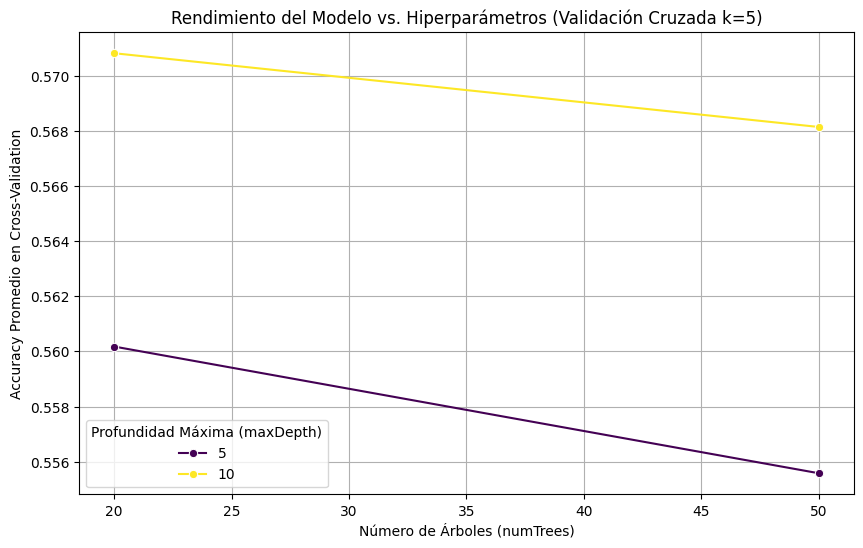

In [ ]:
# Extraer los resultados de la validación cruzada
avg_metrics = cvModel.avgMetrics

# Crear un DataFrame de pandas para facilitar la visualización
results = []
for params, metric in zip(paramGrid, avg_metrics):
    results.append({
        'numTrees': params[rf.numTrees],
        'maxDepth': params[rf.maxDepth],
        'accuracy': metric
    })
results_df = pd.DataFrame(results)

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='numTrees', y='accuracy', hue='maxDepth', marker='o', palette='viridis')
plt.title('Rendimiento del Modelo vs. Hiperparámetros (Validación Cruzada k=5)')
plt.xlabel('Número de Árboles (numTrees)')
plt.ylabel('Accuracy Promedio en Cross-Validation')
plt.grid(True)
plt.legend(title='Profundidad Máxima (maxDepth)')
plt.show()

### 4.2. Evaluación del Mejor Modelo
Una vez que `CrossValidator` ha identificado los mejores hiperparámetros, reentrena el modelo en todo el conjunto de datos `M_prepared`. Ahora, evaluamos este modelo final utilizando un conjunto de métricas completo. Es importante recordar que esta evaluación se hace sobre los mismos datos de entrenamiento, pero el modelo fue seleccionado por su capacidad de generalizar durante la validación cruzada.

--- Resultados del Mejor Modelo Supervisado ---
Accuracy: 0.5760
Weighted Precision: 0.6556
Weighted Recall: 0.5760
F1 Score: 0.4907


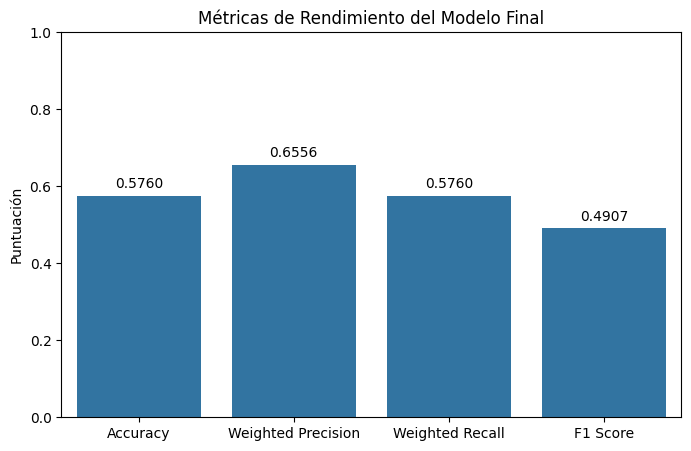

In [ ]:
# Realizar predicciones con el mejor modelo encontrado por CV
predictions = cvModel.transform(M_prepared)

# Usaremos múltiples evaluadores para obtener diferentes métricas
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="f1")

# Calcular métricas
accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

metrics = {'Accuracy': accuracy, 'Weighted Precision': precision, 'Weighted Recall': recall, 'F1 Score': f1}

print("--- Resultados del Mejor Modelo Supervisado ---")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Visualizar las métricas
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title('Métricas de Rendimiento del Modelo Final')
plt.ylabel('Puntuación')
plt.ylim(0, 1)
for index, value in enumerate(list(metrics.values())):
    plt.text(index, value + 0.02, f'{value:.4f}', ha='center')
plt.show()

### 4.3. Matriz de Confusión
La matriz de confusión es una de las herramientas de visualización más importantes para un problema de clasificación. Nos permite ver en detalle el rendimiento del modelo para cada clase, mostrando los aciertos (la diagonal principal) y los errores (fuera de la diagonal). Es especialmente útil para identificar qué clases son confundidas entre sí, un aspecto clave en datasets desbalanceados.

   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   --- ------------------------------------ 1.0/10.7 MB 5.6 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/10.7 MB 5.8 MB/s eta 0:00:02
   ------------- -------------------------- 3.7/10.7 MB 6.1 MB/s eta 0:00:02
   ------------------ --------------------- 5.0/10.7 MB 6.2 MB/s eta 0:00:01
   ------------------------ --------------- 6.6/10.7 MB 6.3 MB/s eta 0:00:01
   ------------------------------ --------- 8.1/10.7 MB 6.5 MB/s eta 0:00:01
   ----------------------------------- ---- 9.4/10.7 MB 6.5 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 6.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   - -------------------------------------- 1.3/41.0 MB 7.4 MB/s eta 0:00:06
   -- ------------------------------------- 2.9/41.0 MB 7.3 MB/s eta 0:00:06
   ---- ----------------------------------- 4.5/41.0 MB 7.3 MB/s eta 0:00:06
   ----- ---

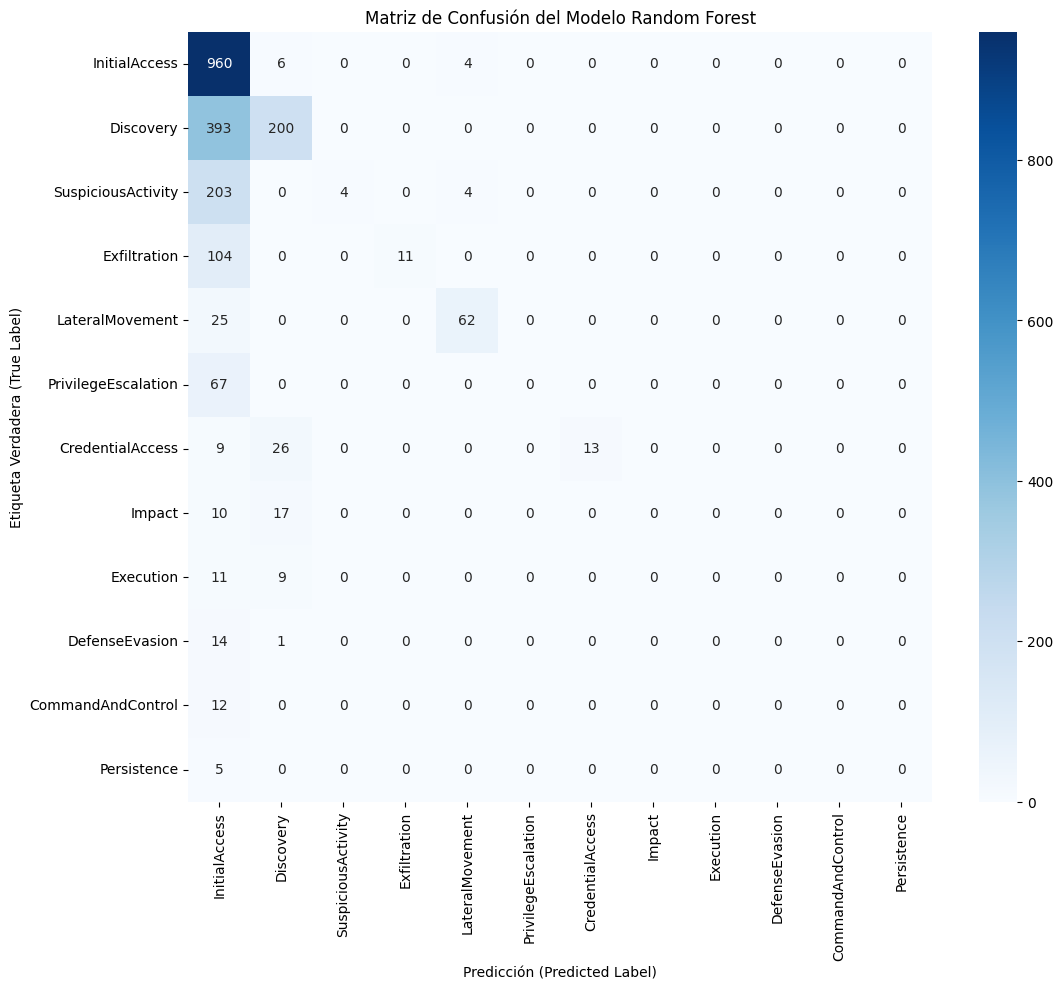

In [ ]:
# Obtener las etiquetas originales de las predicciones e índices
preds_and_labels = predictions.select(['prediction', 'Category_idx']).withColumn('label', F.col('Category_idx')).toPandas()
y_pred = preds_and_labels['prediction']
y_true = preds_and_labels['label']

# Obtener los nombres de las clases desde el modelo StringIndexer que guardamos anteriormente
class_labels = category_indexer_model.labels

# Calcular la matriz de confusión usando scikit-learn
!pip install seaborn scikit-learn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión del Modelo Random Forest')
plt.ylabel('Etiqueta Verdadera (True Label)')
plt.xlabel('Predicción (Predicted Label)')
plt.show()

### 4.4. Modelo No Supervisado (KMeans) y Perfilado de Clústeres

Revisitamos el modelo de clustering para aplicar el paso más importante después del entrenamiento: el **perfilado de clústeres**. El objetivo es entender la composición de cada clúster para darle un significado de negocio. Analizaremos la distribución de las características originales dentro de cada uno de los 5 grupos identificados.

In [ ]:
# Re-entrenamos el modelo KMeans para obtener las predicciones de clúster
k_optimal = 5
kmeans = KMeans(featuresCol="features", k=k_optimal, seed=1)
kmodel = kmeans.fit(M_prepared)
kpredictions = kmodel.transform(M_prepared)

# Evaluar con Silhouette Score
clustering_evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = clustering_evaluator.evaluate(kpredictions)
print(f"Silhouette Coefficient para k={k_optimal}: {silhouette:.4f}\n")

# Perfilado de Clústeres
print("--- Perfilado de Clústeres (Distribución de Características por Clúster) ---")
cluster_profile = kpredictions.groupBy('prediction').agg(
    F.expr('percentile_approx(IncidentGrade_idx, 0.5)').alias('median_IncidentGrade'),
    F.expr('percentile_approx(EntityType_idx, 0.5)').alias('median_EntityType'),
    F.expr('percentile_approx(OSFamily_idx, 0.5)').alias('median_OSFamily')
).orderBy('prediction')

cluster_profile.show(truncate=False)

Silhouette Coefficient para k=5: 0.7942

--- Perfilado de Clústeres (Distribución de Características por Clúster) ---
+----------+--------------------+-----------------+---------------+
|prediction|median_IncidentGrade|median_EntityType|median_OSFamily|
+----------+--------------------+-----------------+---------------+
|0         |0.0                 |0.0              |0.0            |
|1         |0.0                 |0.0              |0.0            |
|2         |1.0                 |0.0              |0.0            |
|3         |0.0                 |0.0              |0.0            |
|4         |2.0                 |0.0              |0.0            |
+----------+--------------------+-----------------+---------------+



# SECCIÓN 5: DISCUSIÓN DE RESULTADOS Y CONCLUSIONES
La aplicación técnicas de aprendizaje supervisado y no supervisado permitió trabajar de manera robusta el análisis de grandes volúmenes de datos relacionados con ciberseguridad, logrando detectar patrones y evaluar el comportamiento del modelo frente a distintas categorías de ataque.

La elección de 5 clústeres demostró ser la adecuada tanto de manera teórica como práctica, como se comprueba con el Silhouette Coefficient de 0.79 en la aplicación del modelo no supervisado. valor que indica una separación clara entre los grupos generados. El perfilado de los clústeres evidenció una clasificación coherente de los incidentes según su severidad (IncidentGrade), destacando la capacidad del modelo para agrupar correctamente eventos con diferentes niveles de impacto.

La partición, realizada acorde a la categoría del ataque, a pesar del fuerte imbalance de las mismas, genera métricas equilibradas en el modelo supervisado, demostrando que el modelo de Random Forest es el adecuado para esta sección del trabajo:

Accuracy: 0.5760
Weighted Precision: 0.6556
Weighted Recall: 0.5760
F1 Score: 0.4907

El modelo de Random Forest demostró ser más preciso con 20 árboles y una profundidad de 10, dentro de un rango de 20-50 árboles por bosque y 5 y 10 rangos de profundidad, con una tendencia a overfitting conforme más árboles se añadían, y demostrando que más profundidad generaba mejores resultados.

Estos valores fueron visualizados mediante una gráfica de barras que facilitó la interpretación comparativa del rendimiento del modelo. Además, la matriz de confusión, representada como mapa de calor, permitió identificar con claridad las clases mejor clasificadas (como InitialAccess), así como aquellas donde el modelo mostró dificultades , muchas veces asociadas a una escasa representación en los datos de entrenamiento.

Los hallazgos obtenidos mediante gráficos de barras, mapas de calor, curvas de evaluación y análisis de clústeres, confirman que el modelo entrenado logró un desempeño sólido, con espacio para futuras mejoras mediante técnicas de balanceo, selección de variables y ajustes más finos de los hiperparámetros.